In [1]:
import warnings 
warnings.filterwarnings('ignore', category=DeprecationWarning)
import numpy as np
import pandas as pd
import scipy # could be irrelevant, possibly needed for scatter_matrix 
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('seaborn')

import tensorflow as tf
tf.compat.v1.disable_eager_execution() 
import tensorflow_probability as tfp
print(tf.__version__) 

import os 
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

2.5.0


In [2]:
tfd = tfp.distributions
tfb = tfp.bijectors

In [3]:
session = tf.compat.v1.Session()
tf.compat.v1.set_random_seed(42)

In [4]:
batch_size=32
DTYPE=tf.float32
NP_DTYPE=np.float32

In [5]:
# print(os.getcwd())
data_dir = '/Users/kaanguney.keklikci/Desktop/Erasmus+/Heidelberg/data/'
data = pd.read_excel(data_dir+'prostate.xls', engine='xlrd')
data.head()

*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'


,patno,stage,rx,dtime,status,age,wt,pf,hx,sbp,dbp,ekg,hg,sz,sg,ap,bm,sdate
0,1,3,0.2 mg estrogen,72,alive,75.0,76.0,normal activity,0,15,9,heart strain,13.798828,2.0,8.0,0.299988,0,2778
1,2,3,0.2 mg estrogen,1,dead - other ca,54.0,116.0,normal activity,0,13,7,heart block or conduction def,14.599609,42.0,NaN,0.699951,0,2820
2,3,3,5.0 mg estrogen,40,dead - cerebrovascular,69.0,102.0,normal activity,1,14,8,heart strain,13.398438,3.0,9.0,0.299988,0,2933
3,4,3,0.2 mg estrogen,20,dead - cerebrovascular,75.0,94.0,in bed < 50% daytime,1,14,7,benign,17.597656,4.0,8.0,0.899902,0,2999
4,5,3,placebo,65,alive,67.0,99.0,normal activity,0,17,10,normal,13.398438,34.0,8.0,0.500000,0,3002


In [6]:
data.isnull().sum()

patno      0
stage      0
rx         0
dtime      0
status     0
age        1
wt         2
pf         0
hx         0
sbp        0
dbp        0
ekg        8
hg         0
sz         5
sg        11
ap         0
bm         0
sdate      0
dtype: int64

In [7]:
# impute missing values
data = data.dropna(subset = ['ekg', 'age'])
data['sz'] = data['sz'].fillna(value = np.mean(data['sz']))
data['sg'] = data['sg'].fillna(value = np.mean(data["sg"]))
data['wt'] = data['wt'].fillna(value = np.mean(data['wt']))

# check if all are imputed 
assert(data.isnull().all().sum() == 0)

In [8]:
data.shape, data.describe()

((493, 18),
             patno       stage       dtime         age          wt          hx  \
 count  493.000000  493.000000  493.000000  493.000000  493.000000  493.000000   
 mean   251.176471    3.423935   36.121704   71.444219   99.132383    0.432049   
 std    145.927533    0.494682   23.311024    7.035583   13.361332    0.495864   
 min      1.000000    3.000000    0.000000   48.000000   69.000000    0.000000   
 25%    125.000000    3.000000   14.000000   70.000000   90.000000    0.000000   
 50%    249.000000    3.000000   34.000000   73.000000   98.000000    0.000000   
 75%    377.000000    4.000000   57.000000   76.000000  107.000000    1.000000   
 max    506.000000    4.000000   76.000000   89.000000  152.000000    1.000000   
 
               sbp         dbp          hg          sz          sg          ap  \
 count  493.000000  493.000000  493.000000  493.000000  493.000000  493.000000   
 mean    14.363083    8.156187   13.445493   14.481557   10.307054   12.210995   
 s

In [9]:
data.drop(['patno', 'sdate'], axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)

In [10]:
print(data.rx.unique())
print(data.ekg.unique())
print(data.pf.unique())
data = pd.get_dummies(data)

['0.2 mg estrogen' '5.0 mg estrogen' 'placebo' '1.0 mg estrogen']
['heart strain' 'heart block or conduction def' 'benign' 'normal' 'old MI'
 'rhythmic disturb & electrolyte ch' 'recent MI']
['normal activity' 'in bed < 50% daytime' 'in bed > 50% daytime'
 'confined to bed']


In [11]:
columns = data.columns 
data = StandardScaler().fit_transform(data) # returns values, not dataframe
data = pd.DataFrame(data,columns=columns) 
data.head()

,stage,dtime,age,wt,hx,sbp,dbp,hg,sz,sg,...,pf_in bed < 50% daytime,pf_in bed > 50% daytime,pf_normal activity,ekg_benign,ekg_heart block or conduction def,ekg_heart strain,ekg_normal,ekg_old MI,ekg_recent MI,ekg_rhythmic disturb & electrolyte ch
0,-0.857855,1.540676,0.505913,-1.733052,-0.872189,0.264622,0.572507,0.180493,-1.023625,-1.153950,...,-0.280668,-0.16457,0.339683,-0.221215,-0.235954,1.519449,-0.718974,-0.423587,-0.045083,-0.339683
1,-0.857855,-1.508187,-2.481946,1.263703,-0.872189,-0.566325,-0.784444,0.589552,2.256814,0.000000,...,-0.280668,-0.16457,0.339683,-0.221215,4.238106,-0.658133,-0.718974,-0.423587,-0.045083,-0.339683
2,-0.857855,0.166541,-0.347761,0.214839,1.146540,-0.150852,-0.105969,-0.024037,-0.941614,-0.653766,...,-0.280668,-0.16457,0.339683,-0.221215,-0.235954,1.519449,-0.718974,-0.423587,-0.045083,-0.339683
3,-0.857855,-0.692294,0.505913,-0.384512,1.146540,-0.150852,-0.784444,2.121031,-0.859603,-1.153950,...,3.562926,-0.16457,-2.943920,4.520485,-0.235954,-0.658133,-0.718974,-0.423587,-0.045083,-0.339683
4,-0.857855,1.240084,-0.632319,-0.009918,-0.872189,1.095570,1.250982,-0.024037,1.600726,-1.153950,...,-0.280668,-0.16457,0.339683,-0.221215,-0.235954,-0.658133,1.390872,-0.423587,-0.045083,-0.339683


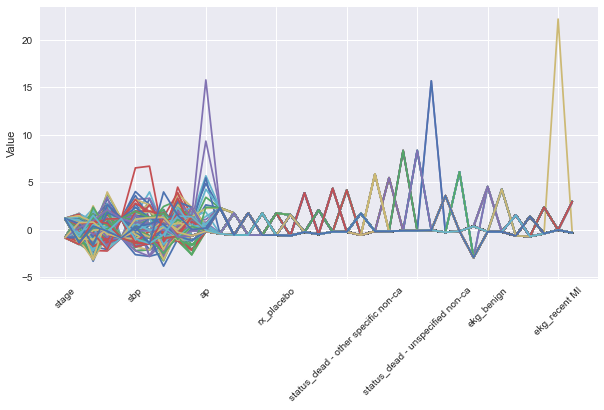

In [12]:
# visualize the figure as line plot for each row 
# remove legend, too long
data.T.plot(figsize=(10,5))
plt.xticks(rotation=45)
plt.legend().remove()
plt.ylabel('Value')
plt.show() 

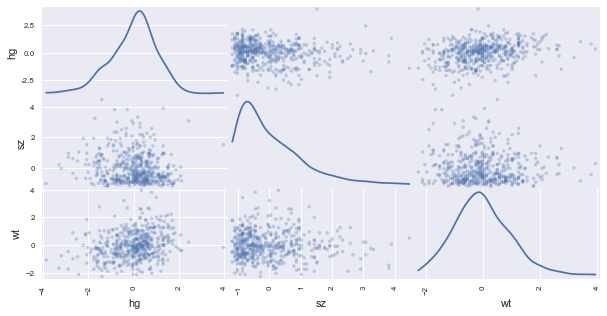

In [13]:
# alternative visualization: plot densities of hg, sz, wt
scatter_matrix(data[['hg','sz','wt']], figsize=(10,5),diagonal='kde',alpha=0.3)
plt.show()

In [14]:
""" dataset tensor definition """
dataset = tf.data.Dataset.from_tensor_slices(data.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=data.shape[0])
dataset = dataset.prefetch(2*batch_size)
dataset = dataset.batch(batch_size)
data_iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
x_samples = data_iterator.get_next()

In [15]:
dims = data.shape[1]
print('Dimension count: ' + str(dims))

Dimension count: 37


In [16]:
nvp = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[dims]),
    bijector=tfb.RealNVP(
        num_masked=dims-1,
        shift_and_log_scale_fn=tfb.real_nvp_default_template(
            hidden_layers=[512, 512], shift_only=True), is_constant_jacobian=True))

In [18]:
""" define adam as optimizer, minimize negative log likelihood """
# loss may become negative, note that it's just a scalar 
loss = -tf.reduce_mean(nvp.log_prob(x_samples))
train_op = tf.compat.v1.train.AdamOptimizer(1e-4).minimize(loss)

In [19]:
session.run(tf.compat.v1.global_variables_initializer())

Iteration 0: 60.184722900390625
Iteration 10000: 50.05358123779297
Iteration 20000: 49.8468017578125
Iteration 30000: 49.18869400024414
Iteration 40000: 50.25196838378906
Iteration 50000: 52.78778839111328
Iteration 60000: 58.92238998413086
Iteration 70000: 51.21335983276367
Iteration 80000: 55.31623458862305
Iteration 90000: 57.86042785644531


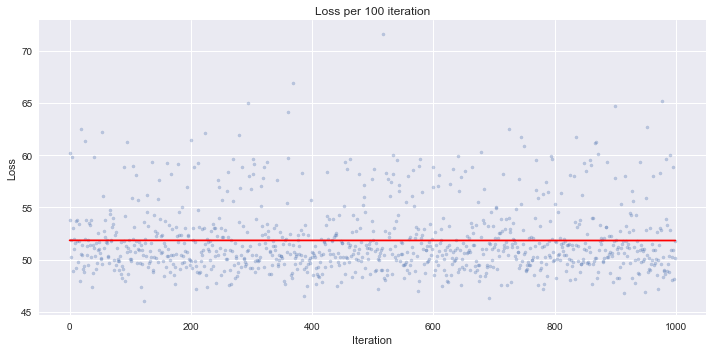

In [20]:
""" optimize for all dimensions """
NUM_STEPS = int(1e5)
global_step = []
np_losses = []
for i in range(NUM_STEPS):
    _, np_loss = session.run([train_op, loss])
    if i % 100 == 0:
        global_step.append(i)
        np_losses.append(np_loss)
    if i % int(1e4) == 0:
        print('Iteration {iteration}: {loss}'.format(iteration=i,loss=np_loss))
        
""" plot loss """
fig = plt.figure(figsize=(10,5))
x = np.arange(1000)
y = np_losses
m, b = np.polyfit(x, y, 1) 
plt.scatter(x, y, s=10, alpha=0.3)
plt.plot(x, m*x+b, c="r")
plt.title('Loss per 100 iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()